### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors
from helpers import helpers, plotter
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150, ordered = False, same_x = True)

In [4]:
import numpy as np

# goes with check 61
np.save('/Users/omernivron/Downloads/pad_pos_tr', pad_pos_tr)

np.save('/Users/omernivron/Downloads/pad_pos_te', pad_pos_te)

np.save('/Users/omernivron/Downloads/pad_y_fren_tr', pad_y_fren_tr)

np.save('/Users/omernivron/Downloads/pad_y_fren_te', pad_y_fren_te)

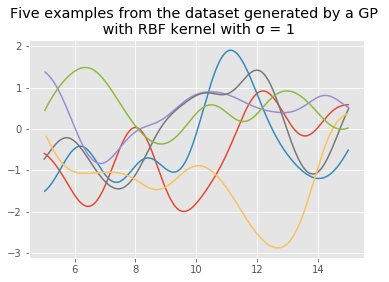

In [5]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [6]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [7]:
batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
batch_pos_tr1 = batch_pos_tr[:, :-1]
batch_pos_tr_current = batch_pos_tr[:, 1:]

In [8]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

In [9]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    decoder = experimental_model.Decoder(256); tf.random.set_seed(443)   
    EPOCHS = 25; batch_s  = 64; run = 301; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
#     num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
#                 batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
#                 batch_pos_tr1 = batch_pos_tr[:, :-1]
#                 batch_pos_tr_current = batch_pos_tr[:, 1:]
                pred, pred_log = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr1, batch_pos_tr_current, batch_tar_tr)
                
                if batch_n % 1500 == 0:
#                     plotter.sample_plot_w_training(batch_pos_tr_current[1, :], batch_tar_tr[1, 1:], pred[1, :], title = 'training progress')
                    pos_te1 = pad_pos_te[:, :-1]
                    pos_te_current = pad_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pos_te1[:500, :], pos_te_current[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr_current, batch_tar_tr[:, 1:], pred, pos_te_current[:500, :], pad_y_fren_te[:500, 1:], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Initializing from scratch.
tar:  Tensor("decoder/concat:0", shape=(2, 599, 2), dtype=float64)
q1:  Tensor("decoder/wq/BiasAdd:0", shape=(2, 599, 256), dtype=float64)
q:  Tensor("decoder/Squeeze:0", shape=(2, 599, 256), dtype=float64)
tar:  Tensor("decoder/concat:0", shape=(2, 599, 2), dtype=float64)


ValueError: in user code:

    ../model/grapher.py:38 train_step  *
        pred = decoder(pos, curr_pos, tar_inp, True, combined_mask_pos , combined_mask_tar)
    ../model/experimental_model.py:65 call  *
        v = self.wk(tar_inp)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__  **
        self.name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer wk is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [2, 599, 1]
